In [13]:
!pip install wbdata -q

  Obtaining dependency information for wbdata from https://files.pythonhosted.org/packages/f0/60/fa9661d0480d6f62642feeff217b86b60946cba8c7f04d35d6e342ef4309/wbdata-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for cachetools<6.0.0,>=5.3.2 from https://files.pythonhosted.org/packages/a4/07/14f8ad37f2d12a5ce41206c21820d8cb6561b728e51fad4530dff0552a67/cachetools-5.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for dateparser<2.0.0,>=1.2.0 from https://files.pythonhosted.org/packages/a4/29/db12aa4dda81580be1999824a689bd52aa40061fc12c9ccdc3feab5ea718/dateparser-1.2.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for shelved-cache<0.4.0,>=0.3.1 from https://files.pythonhosted.org/packages/09/b6/621bc73492accf30a584291c45a4ceb7524b371d5e2df64213e8430d56b6/shelved_cache-0.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for tabulate<0.9.0,>=0.8.5 from https://files.pythonhosted.org/packages/92/4e/e5a13fdb3e6f81ce1189352

In [60]:
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

# Fetch data using wbdata
# Fetch GDP per capita data
#countries = ["USA"] # United States
countries = ["USA"]
indicators = {"NY.GDP.PCAP.CD": "GDP per capita"}
data = wbdata.get_dataframe(indicators, country=countries)
data = data.reset_index()

# Prepare the data
data = data.sort_values("date")
data = data.rename(columns={"NY.GDP.PCAP.CD": "GDP_per_capita"})
data['Year'] = pd.to_datetime(data['date']).dt.year

# Remove any rows with NaN or inf values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# replace spaces with undersecore
data.columns = data.columns.str.replace(' ', '_')

# Ensure we have valid numeric data
data['GDP_per_capita'] = pd.to_numeric(data['GDP_per_capita'], errors='coerce')
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
data = data.drop(columns=['date'])
data = data.dropna()
data

,GDP_per_capita,Year
63,2999.864872,1960
62,3059.160821,1961
61,3236.013112,1962
60,3366.369790,1963
59,3565.314430,1964
...,...,...
4,65548.070785,2019
3,64317.398913,2020
2,71055.876194,2021
1,77246.673883,2022


In [61]:
data.to_csv("../datasets/gdp_per_capita.csv", index=False)

In [54]:
# Function to plot regression results
def plot_regression(x, y, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5)
    plt.plot(x, y_pred, color='red', linewidth=2)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Function to plot residuals
def plot_residuals(x, residuals, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Residuals')
    plt.show()

# Function to create Q-Q plot
def plot_qq(residuals, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.set_title(title)
    plt.show()

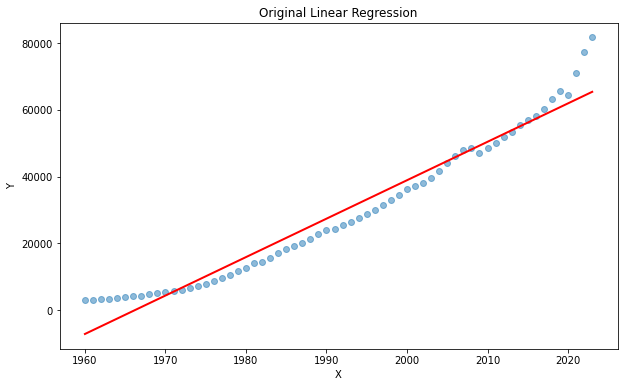

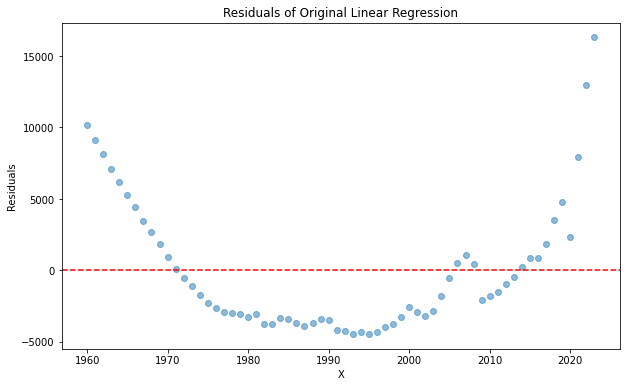

Original R-squared: 0.9559531721901393
Original MSE: 20881419.83785289


In [55]:
# Original Linear Regression
X = sm.add_constant(data['Year'])
model = sm.OLS(data['GDP_per_capita'], X).fit()
y_pred = model.predict(X)
residuals = data['GDP_per_capita'] - y_pred

plot_regression(data['Year'], data['GDP_per_capita'], y_pred, 'Original Linear Regression')
plot_residuals(data['Year'], residuals, 'Residuals of Original Linear Regression')

print("Original R-squared:", r2_score(data['GDP_per_capita'], y_pred))
print("Original MSE:", mean_squared_error(data['GDP_per_capita'], y_pred))


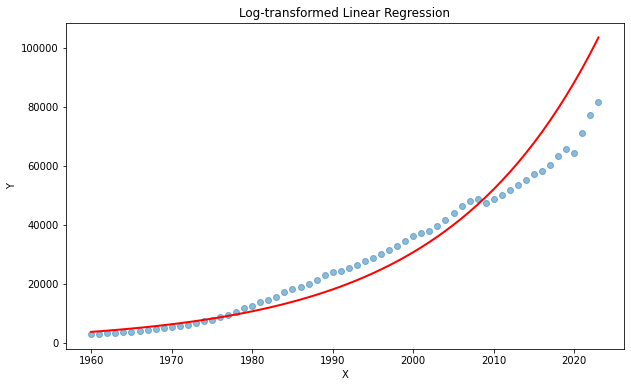

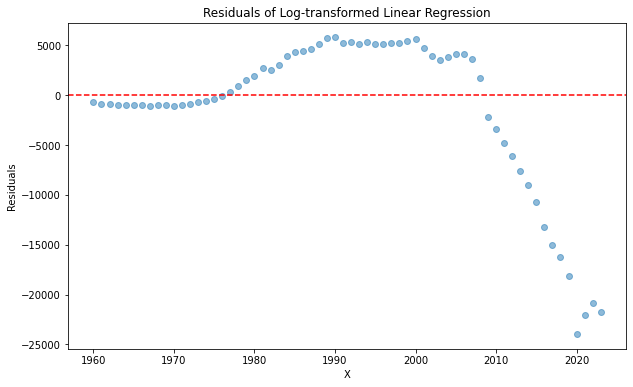

Log-transformed R-squared: 0.8716709522842584
Log-transformed MSE: 60837360.05489044


In [56]:
# Log-transformed Linear Regression
data['log_GDP_per_capita'] = np.log(data['GDP_per_capita'])
model_log = sm.OLS(data['log_GDP_per_capita'], X).fit()
y_pred_log = np.exp(model_log.predict(X))
residuals_log = data['GDP_per_capita'] - y_pred_log

plot_regression(data['Year'], data['GDP_per_capita'], y_pred_log, 'Log-transformed Linear Regression')
plot_residuals(data['Year'], residuals_log, 'Residuals of Log-transformed Linear Regression')

print("Log-transformed R-squared:", r2_score(data['GDP_per_capita'], y_pred_log))
print("Log-transformed MSE:", mean_squared_error(data['GDP_per_capita'], y_pred_log))


In [42]:
print("\nOriginal Model Summary:")
model.summary()


Original Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         GDP_per_capita   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1346.
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           9.44e-44
Time:                        17:37:58   Log-Likelihood:                -630.15
No. Observations:                  64   AIC:                             1264.
Df Residuals:                      62   BIC:                             1269.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.266e+06   6.26e+04    -36.216      0.000   -2.39e+06   -2.14e+06
Year        1152.4038     31.416     36.682      0.000    1089.605    1215.203
==============================================================================
Omnibus:                       23.557   Durbin-Watson:                   0.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.080
Skew:                           1.489   Prob(JB):                     6.56e-08
Kurtosis:                       4.880   Cond. No.                     2.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
print("\nLog-transformed Model Summary:")
model_log.summary()


Log-transformed Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_GDP_per_capita   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     1593.
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           6.22e-46
Time:                        17:37:59   Log-Likelihood:                 14.657
No. Observations:                  64   AIC:                            -25.31
Df Residuals:                      62   BIC:                            -21.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -95.2786      2.635    -36.160      0.000    -100.546     -90.011
Year           0.0528      0.001     39.912      0.000       0.050       0.055
==============================================================================
Omnibus:                      103.773   Durbin-Watson:                   0.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.481
Skew:                          -0.010   Prob(JB):                       0.0391
Kurtosis:                       1.441   Cond. No.                     2.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""